In [198]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim

In [199]:
data = pd.read_csv('data/fetch_california_housing.csv')
data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [200]:
# X, y 데이터를 분리
# X = data.iloc[:,:-1]
# y = data.iloc[:,-1:]

X = data.drop(columns='MedHouseVal')
y = data['MedHouseVal']
print(X)
print(y)

       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
...       ...       ...       ...        ...         ...       ...       ...   
20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   

       Longitude  
0        -122.23  
1

In [201]:
# Train /Test 데이터셋 분리 (Train_test_split 옵션 X,y,20%, 시드 42)

X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=0.2,
    random_state=42,
)

print(X_train.sum(), X_test.sum(), y_train.sum(), y_test.sum())

MedInc        6.407901e+04
HouseAge      4.723800e+05
AveRooms      8.974660e+04
AveBedrms     1.810846e+04
Population    2.355359e+07
AveOccup      5.113702e+04
Latitude      5.885397e+05
Longitude    -1.974543e+06
dtype: float64 MedInc        1.581164e+04
HouseAge      1.187390e+05
AveRooms      2.230795e+04
AveBedrms     4.526917e+03
Population    5.868248e+06
AveOccup      1.224130e+04
Latitude      1.469019e+05
Longitude    -4.933759e+05
dtype: float64 34211.98783 8483.05278


In [202]:
X_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)            # train 데이터로 평균 0, 표준편차 1 학습 및 변환
X_test_scaled = X_scaler.transform(X_test)                  # train 데이터를 기준으로 test 데이터를 변환


In [203]:
# 데이터프레임 형태로 다시 만들어주기
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    columns= X_train.columns,
    index = X_train.index
)

X_test_scaled = pd.DataFrame(
    X_test_scaled,
    columns= X_test.columns,
    index = X_test.index
)

linear 레이어가 2차원 출력으로 나온다 (N, out_features) - y_hat(예측값), y의 형태를 맞춰준다. 
이걸 맞춰주지 않으면 yi_train은 (16512,) 1차원. y_hat(16512, 1) 이걸로 loss계산을 할 때 loss값이 생각과 다르게 나온다.


In [204]:
# DataFrame 을 pythorch 텐서로 변환해서 모델 학습 준비
# X_train_tensor = torch.FloatTensor(X_train_scaled.to_numpy).float()
X_train_tensor = torch.from_numpy(X_train_scaled.to_numpy()).float()          # train 입력 데이터를 pythorch Tensor(float)로 변환
X_test_tensor = torch.from_numpy(X_test_scaled.to_numpy()).float()            # test 입력 데이터를 pythorch Tensor(float)로 변환

y_train_tensor = torch.from_numpy(y_train.values).float().view(-1, 1)         # 타깃 데이터는 (샘플 수, 1) 형태로 변환
y_test_tensor = torch.from_numpy(y_test.values).float().view(-1, 1)           # 출력 차원을 맞춰주기 위한 reshape

print(X_train_tensor.size(), X_test_tensor.size(), y_train_tensor.size(), y_test_tensor.size())

torch.Size([16512, 8]) torch.Size([4128, 8]) torch.Size([16512, 1]) torch.Size([4128, 1])


In [ ]:
# 하이퍼파라미터 설정
n_epochs = 5000             # 학습 반복 횟수
learning_rate = 1e-3        # 학습률(0.001)
print_interval = 500        # 학습 손실 출력 주기
early_stop = 50


모델 (nn.Sequntial)을 사용해서 3개의 은닉층과 ReLU 활성화를 갖는 심층 회귀 모델
- 입력 -> 은닉 -> 은닉 -> 은닉 -> 출력

In [206]:
model = nn.Sequential(
    nn.Linear(X_train_tensor.size(-1),64),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    
    nn.Linear(32, y_train_tensor.size(-1)),
)

In [ ]:
optimizer = optim.Adam(     # adam : 모멘텀 + RMSProp 결합한 최적화 알고리즘
    model.parameters(),     # 학습 대상이 되는 모든 가중치, 편향 파라미터
    lr = learning_rate,     # 학습률        
)


In [208]:
# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modle = model.to(device)
X_train = X_train_tensor.to(device)
y_train = y_train_tensor.to(device)
X_test = X_test_tensor.to(device)
y_test = y_test_tensor.to(device)


model.train() 
- 무조건 써야되는 상황 : 딥러닝 모델안에서 Dropout(), BatchNorm() 사용할 시 (과적합 방지용으로 거의 들어간다.)

In [212]:
# 학습 루프
for epoch in range(n_epochs):
    model.train()               # 학습 모드 (딥러닝 모델안에)
    
    y_hat = model(X_train)      # 순전파
    loss = F.mse_loss(y_hat, y_train)   # 평균제곱오차 손실 계산
    
    optimizer.zero_grad()       # 이전 step 기울기 초기화
    loss.backward()             # 역전파 : 손실을 기준으로 gradient 계산
    
    optimizer.step()            # 파라미터 업데이트
    
    
    
    if (epoch + 1) % print_interval == 0 :
        print(f"Epoch : {epoch+1}의 train_loss = {loss.item():.4f}")
        
# 테스트 손실 출력
model.eval()
    
with torch.no_grad():                               # 이 안에서는 기울기 계산 비활성화
    y_pred_test = model(X_test)                     # 테스트 데이터로 예측
    test_loss = F.mse_loss(y_pred_test, y_test)     # 테스트 손실 계산
    
print(f"Test MSE: {test_loss.item():.4f}")

Epoch : 500의 train_loss = 0.2669
Epoch : 1000의 train_loss = 0.2638
Epoch : 1500의 train_loss = 0.2587
Epoch : 2000의 train_loss = 0.2592
Epoch : 2500의 train_loss = 0.2499
Epoch : 3000의 train_loss = 0.2485
Epoch : 3500의 train_loss = 0.2475
Epoch : 4000의 train_loss = 0.2480
Epoch : 4500의 train_loss = 0.2450
Epoch : 5000의 train_loss = 0.2446
Test MSE: 0.2419


### nn.Linear를 활용하여 선형 연산 구현

In [210]:
# 시각화
model.eval()
with torch.no_grad():
    y_pred = model(X_test).cpu().numpy().reshape(-1)    # 예측값을 CPU -> Numpy 변환 -> 1차원 배열로 형태 변환
    y_true = y_test.cpu().numpy().reshape(-1)           # 실제값을 CPU -> Numpy -> 1차원 배열로 형태 변환
    
df_result = pd.DataFrame(
    {
        "y" : y_true,
        "y_hat" : y_pred
    }
    
)

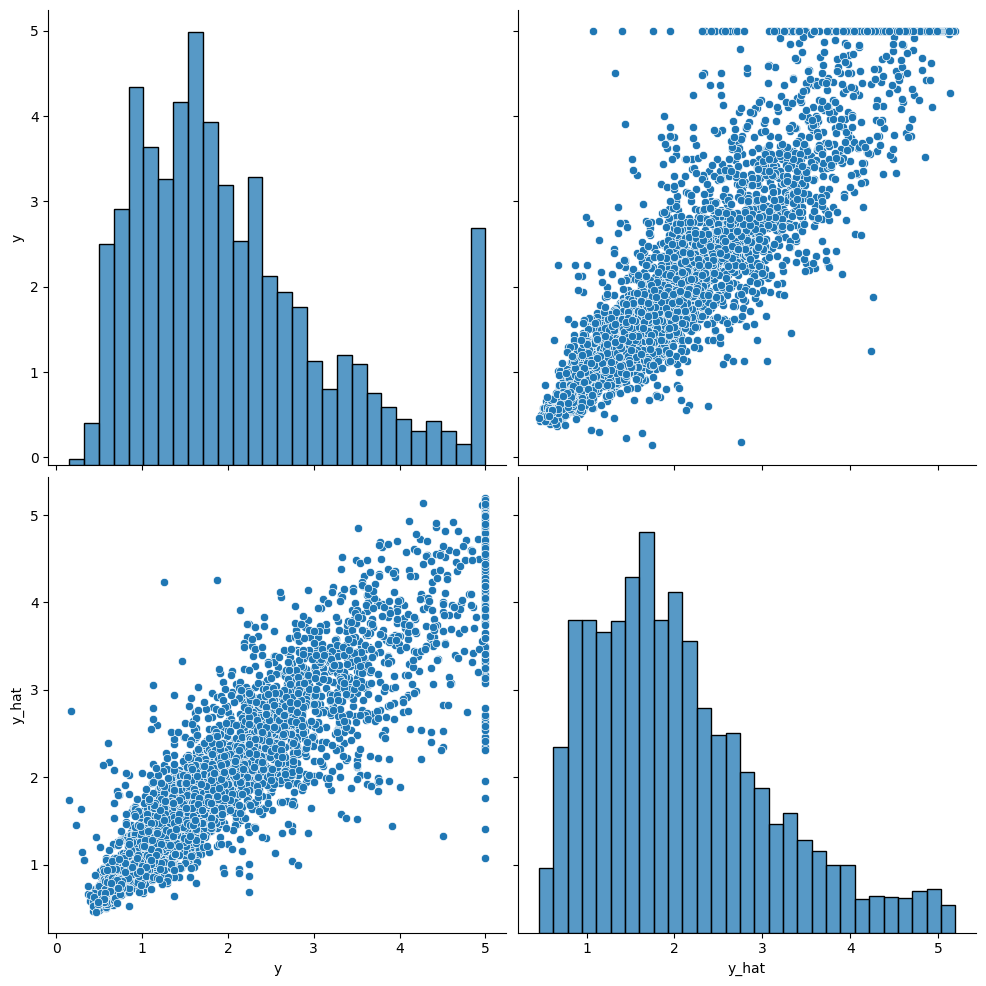

In [211]:
sns.pairplot(df_result, height=5)
plt.show()

# 성능을 끌어올려보자 (현재 test MSE : 3.3e-1)
- 은닉층 줄이거나 늘려본다.
- 과적합시에는 Dropout or batchNorm같은것도 딥러닝 모델안에 넣어본다.
- lr별도로 비교해보기
- epochs 늘려본다. (과적합 방지를 위해 early stopping도 넣어본다.)
- 데이터가 많지 않으므로 머신러닝 모델도 넣어본다.

In [ ]:
# 학습 루프
train_history, valid_history = [], []  # 학습/검증 손실 기록 리스트

for i in range(n_epochs):
    indices = torch.randperm(X_train.size(0), device=X_train.device)
    x_ = torch.index_select(X_train, dim=0, index=indices)
    y_ = torch.index_select(y_train, dim=0, index=indices)
    x_ = torch.index_select(X_train, dim=0, index=indices) # 셔플된 X
    y_ = torch.index_select(y_train, dim=0, index=indices) # 셔플된 y
    
    x_ = x_.split(batch_size, dim=0)        # 배치 크기(32) 단위로 분할
    y_ = y_.split(batch_size, dim=0)        # 배치 크기(32) 단위로 분할

    train_loss, valid_loss = 0,0            # epoch별 손실 초기화
    y_hat = []                              # 검증 예측값 저장용 리스트
    
    # 미니 배치 단위로 학습루프
    model.train()
    for x_i, y_i in zip(x_,y_):             # 미니배치 학습 루프
        y_hat_i = model(x_i)                # 순전파
       
        # loss = F.binary_cross_entropy(y_hat_i, y_i) # 이진 분류 손실 계산
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()               # 이전 기울기 초기화
        loss.backward()                     # 가중치 업데이트
        
        optimizer.step()                    # 가중치 업데이트
        train_loss += loss.item()           # Tensor -> float (메모리 누수 방지)
        
    train_loss = train_loss / len(x_)       # 평균 학습 손실 계산


    model.eval()
    with torch.no_grad():                   # 검증 단계 (gradient 계산 안함)
        x_ = X_train.split(batch_size, dim=0)  # 검증 데이터 배치 분할
        y_ = y_train.split(batch_size, dim=0)  # 검증 데이터 배치 분할
        
        valid_loss = 0
        
        # 검증 데이터를 순회 (미니 배치 단위)
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)            # 검증용 순전파
            #loss = F.binary_cross_entropy(y_hat_i, y_i) # 검증 손실 계산
            loss = F.mse_loss(y_hat_i, y_i)

            valid_loss += loss.item()       # 손실 누적
            
            y_hat += [y_hat_i]              # 예측값 저장
            
    valid_loss = valid_loss / len(x_)       # 평균 검증 손실 계산
    
    train_history += [train_loss]           # 평균 학습 손실 누적
    valid_history += [valid_loss]           # 평균 검증 손실 누적
    
    # 100 epoch마다 각종 손실 지표 및 가장 낮은 손실 출력
    if (i + 1)  % print_interval == 0:
        print(f"Epoch : {i+1}, train_loss: {train_loss:.4e}, valid_loss: {valid_loss:.4e}, lowest_loss: {lowest_loss:.4e}")
        
    if valid_loss <= lowest_loss :      # 검증 손실이 개선될 때
        lowest_loss = valid_loss        # 최소 손실 갱실
        lowest_epoch = i                # 해당 epoch 저장
        
        best_model = deepcopy(model.state_dict())   # 최적 모델 가중치 저장
    else:
        # early_stop 설정 and 최고 성능 이후 허용 대기 시간 < 현재 인덱스 일 경우 학습 종료
        if early_stop > 0 and lowest_epoch + early_stop < i + 1 :
            print(f"{early_stop} epoch동안 개선된 사항이 없음")
            break
    
print(f"epoch {lowest_epoch + 1}에서 최고 성능의 Test MSE 손실은? {lowest_loss}")    

model.load_state_dict(best_model) # 최고 성능 모델

